---
title: Programming Assignment 4
author: Péter Ferenc Gyarmati (11913446)
date: '2023.12.15'
format:
    html:
        code-fold: true
---

# Task 1: Movie Recommendation

In this task you will work with the “MovieLens 1M” data set [3], a benchmark dataset for building recommender systems. Your goal is to train a machine learning model for predicting how users would rate different movies based on user and movie features.

## Subtask 1: Data Loading and Data Preparation

Download the dataset from the link provided in the bibliography and unzip it. Read the included README file. Write functions to load and process the user information, the movie information and the ratings from `users.dat`, `movies.dat` and `ratings.dat`, respectively, and construct training data (feature vectors from user and movie data, as well as targets from the ratings) such that based on this data we can train a classifier to predict a user’s movie ratings. Consider the following points:

- The ratings are given as 1-star to 5-star ratings. Consider those as classes 1,...,5.
- When loading the data for processing, think ahead (read the description of all subtasks first) as you will need to construct feature vectors from the data which will then be processed by various machine learning models. In particular, the ratings correspond to labels we want to predict and the features you construct from the user and movie data should contain useful information for predicting that label.
- Remove all users which have rated less than 100 movies.
- Split the data into training and test data. Construct the test data from all the ratings of users with user ids 1,...,1000 (unless a user was removed). Use the remaining ratings to construct the training data.

- [ ] In the report, describe the feature vectors you created. Explain how you represented features and why?
- [ ] How many samples does your training and test data contain?

*Hint 1: You can ignore the zip-code (in the user information) and the time stamp (in the ratings information) for simplicity.*

*Hint 2: Store intermediate results, e.g., after loading the user file and bringing it into a suitable format, to minimize processing time.*

*Remark: The specific way in which we are using the data here is not the most common one. Hence, when reading literature on recommender systems don't be confused.*

### Loading the Data

I got started by creating a function to load the data from the `.dat` files. It was an interesting, mild-migraine-invoking ~15 minutes to figure out why I kept getting an encoding mismatch error when calling `pd.read_csv`. After some trial and error, I found out that I must load the files using `ISO-8859-1` encoding. 

In [45]:
from pathlib import Path
import pandas as pd

raw_data_cache = {}


def load_data(path: Path, columns: list[str]) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep="::",
        encoding="ISO-8859-1",
        header=None,
        names=columns,
        engine="python",
    )
    data_name = path.stem
    raw_data_cache[data_name] = df.copy()
    return df

#### Movies

As per the `README`, we have the colums `["MovieID", "Title", "Genres"]`. I noted that `Title` includes the year of release, but since it is coupled with the title string, in this form it is not very useful if we want to feed an ML model. The shape and form of `Genres` is also not very useful because in general we would need a numerical representation of categorical data so that we can come up with a meaningful model.

In [46]:
assets_root = Path(".") / "assets"
data_root = assets_root / "ml-1m"

movies_df = load_data(
    path=(data_root / "movies.dat"), columns=["MovieID", "Title", "Genres"]
)
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Because of the reasons outlined above, I decided to:

- introduce a new column `Decade` by extracting the year from the `Title` and mapping it to a decade like 1990, 2000, etc. This way, we might be able to better relate the movies to each other based on the decade they were released in, as an exact year would be too fine-grained.
- Transform the `Genres` column to a list of genres, so that we can use it easier later

In [47]:
def year_from_title(title: str) -> int:
    """'{title} ({year})' -> year"""
    # We use the fact that the year is always 4 digits long
    # and is enclosed in parentheses
    trimmed_title = title.strip()
    return int(trimmed_title[-5:-1])


def year_to_decade(year: int) -> int:
    return year - year % 10


def genres_from_string(genres: str) -> set[str]:
    return sorted(set(genres.strip().split("|")))


def process_movies_df(df: pd.DataFrame) -> pd.DataFrame:
    processed_df = df.copy()
    processed_df["Decade"] = (
        processed_df["Title"].apply(year_from_title).apply(year_to_decade)
    )
    processed_df["Genres"] = processed_df["Genres"].apply(genres_from_string)
    processed_df = processed_df.drop(columns=["Title"])
    return processed_df

The processed movies dataset now has the new, transformed columns.

In [48]:
movies_df = process_movies_df(movies_df)
movies_df.head()

,MovieID,Genres,Decade
0,1,"[Animation, Children's, Comedy]",1990
1,2,"[Adventure, Children's, Fantasy]",1990
2,3,"[Comedy, Romance]",1990
3,4,"[Comedy, Drama]",1990
4,5,[Comedy],1990


### Users

All columns are numerical except `Gender`, so we can go ahead and convert it to a binary value.

In [49]:
users_df = load_data(
    path=(data_root / "users.dat"),
    columns=["UserID", "Gender", "Age", "Occupation", "Zip-code"],
)
users_df = users_df.drop(columns=["Zip-code"])
users_df.head()

,UserID,Gender,Age,Occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


In [50]:
def process_users_df(df: pd.DataFrame) -> pd.DataFrame:
    processed_df = df.copy()
    gender_map = {
        "F": 0,
        "M": 1,
    }
    processed_df["Gender"] = processed_df["Gender"].apply(lambda g: gender_map[g])
    return processed_df

The processed users dataset now has the Gender column encoded as a single binary column, where `0` represents females and `1` represents males.

In [51]:
users_df = process_users_df(users_df)
users_df.head()

,UserID,Gender,Age,Occupation
0,1,0,1,10
1,2,1,56,16
2,3,1,25,15
3,4,1,45,7
4,5,1,25,20


### Ratings

The `Ratings` dataset is the most straightforward one, it gives us the foreign keys and the ratings (a.k.a. labels) for each user-movie pair. We can use this dataset as-is.

In [52]:
ratings_df = load_data(
    path=(data_root / "ratings.dat"),
    columns=["UserID", "MovieID", "Rating", "Timestamp"],
)
ratings_df = ratings_df.drop(columns=["Timestamp"])
ratings_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### Filtering & Merging the Datasets

We start by keeping only those users and their ratings who have rated at least 100 movies.

In [53]:
ratings_count = ratings_df.groupby("UserID").size()
users_with_at_least_100_ratings = ratings_count[ratings_count >= 100].index

In [54]:
users_df = users_df[users_df["UserID"].isin(users_with_at_least_100_ratings)]
users_df.head()

,UserID,Gender,Age,Occupation
1,2,1,56,16
4,5,1,25,20
7,8,1,25,12
8,9,1,25,17
9,10,0,35,1


In [55]:
ratings_df = ratings_df[ratings_df["UserID"].isin(users_with_at_least_100_ratings)]
ratings_df.head()

,UserID,MovieID,Rating
53,2,1357,5
54,2,3068,4
55,2,1537,4
56,2,647,3
57,2,2194,4


Having all three datasets filtered and prepared, we can merge them into a single master `DataFrame` with all the features.

⚠️ **Note**: I had to limit the size of the data to $5000$ samples to finish the computations in a reasonable amount of time. I started to work on this assignment late. Late as in *very late*, a few hours before the deadline. As the computations on the full dataset never wanted to finish on my machine, I decided to do the evaluation on a random subset of the data. I am taking a random sample from the dataset, so the whole dataset should be reflected to some extent in the sample.

In [56]:
features_df = (
    ratings_df.merge(users_df, on="UserID")
    .merge(movies_df, on="MovieID")
    .sample(5_000, random_state=42)
)
features_df.head()

,UserID,MovieID,Rating,Gender,Age,Occupation,Genres,Decade
749517,5597,448,1,0,18,4,[Drama],1990
249893,2167,1356,2,0,25,6,"[Action, Adventure, Sci-Fi]",1990
797112,3618,384,3,1,56,17,[Action],1990
308330,2941,2087,4,1,35,12,"[Animation, Children's, Fantasy, Musical]",1950
703970,4566,1395,4,1,35,17,"[Comedy, Drama]",1980


### Computing Complex Features

Now, having a reduced number of rows, we can compute some interaction features between the users and the movies so that we can capture information that is not available in the dataset on the row-level, only on the dataset-level. For that, I am creating some utility functions to compute interesting aggregate statistics which will hopefully help us make more accurate rating predictions. 

#### Movie Statistics

- `avg_rating_overall`: The average rating of the movie across all users
- `avg_rating_per_gender`: The average rating of the move across genders
- `avg_rating_per_age`: The average rating of the move across age groups
- `avg_rating_per_occupation`: The average rating of the move across occupations

In [57]:
from typing import TypedDict


class MovieStats(TypedDict):
    avg_rating_overall: float
    avg_rating_per_gender: pd.Series
    avg_rating_per_age: pd.Series
    avg_rating_per_occupation: pd.Series


def computes_movie_stats(features_for_movie: pd.DataFrame) -> MovieStats:
    return {
        "avg_rating_overall": features_for_movie["Rating"].mean(),
        "avg_rating_per_gender": features_for_movie.groupby("Gender")["Rating"].mean(),
        "avg_rating_per_age": features_for_movie.groupby("Age")["Rating"].mean(),
        "avg_rating_per_occupation": features_for_movie.groupby("Occupation")[
            "Rating"
        ].mean(),
    }


def compute_all_movie_stats(features_df: pd.DataFrame) -> dict[int, MovieStats]:
    return {
        movie_id: computes_movie_stats(features_for_movie)
        for movie_id, features_for_movie in features_df.groupby("MovieID")
    }

#### User Statistics

- `avg_rating_overall`: The average rating given by the user overall
- `avg_rating_per_genre`: The average rating given by the user per genre
- `avg_rating_per_decade`: The average rating given by the user per decade

In [58]:
class UserStats(TypedDict):
    avg_rating_overall: float
    avg_rating_per_genre: pd.Series
    avg_rating_per_decade: pd.Series


def compute_user_stats(features_for_user: pd.DataFrame) -> UserStats:
    features_by_genre = features_for_user.explode("Genres").groupby("Genres")
    features_by_decade = features_for_user.groupby("Decade")
    return {
        "avg_rating_overall": features_for_user["Rating"].mean(),
        "avg_rating_per_genre": features_by_genre["Rating"].mean(),
        "avg_rating_per_decade": features_by_decade["Rating"].mean(),
    }


def compute_all_user_stats(features_df: pd.DataFrame) -> dict[int, UserStats]:
    return {
        user_id: compute_user_stats(features_for_user)
        for user_id, features_for_user in features_df.groupby("UserID")
    }

#### Interaction Features

We can also compute interaction features to better capture the relationship between users and their movie preferences to enhance the quality of our predictions.

In [59]:
from typing import TypedDict
import pandas as pd
from tqdm import tqdm


class InteractionFeatures(TypedDict):
    movie_avg_overall: float
    gender_preference_strength: float
    age_group_preference_strength: float
    occupation_relevance_strength: float
    genre_preference_strength: float
    decade_preference_strength: float


def compute_interaction_features_for_row(
    movie_stats: MovieStats, user_stats: UserStats, row: pd.Series
) -> InteractionFeatures:
    movie_avg_overall = movie_stats["avg_rating_overall"]

    # Determine the user's gender preference strength for this movie's rating
    expected_rating_given_gender = movie_stats["avg_rating_per_gender"][row["Gender"]]
    gender_preference_strength = expected_rating_given_gender

    # Determine the user's age group preference strength for this movie's rating
    expected_rating_given_age = movie_stats["avg_rating_per_age"][row["Age"]]
    age_group_preference_strength = expected_rating_given_age

    # Determine the user's occupation relevance strength for this movie's rating
    expected_rating_given_occupation = movie_stats["avg_rating_per_occupation"][
        row["Occupation"]
    ]
    occupation_relevance_strength = expected_rating_given_occupation

    # Determine the user's genre preference strength for this movie's rating
    # We'll assume that 'Genres' in the row is a list of genres for the movie
    expected_rating_given_genres = user_stats["avg_rating_per_genre"][
        row["Genres"]
    ].mean()
    genre_preference_strength = expected_rating_given_genres

    # Determine the user's decade preference strength for this movie's rating
    expected_rating_given_decade = user_stats["avg_rating_per_decade"][row["Decade"]]
    decade_preference_strength = movie_avg_overall - expected_rating_given_decade

    return {
        "movie_avg_overall": movie_avg_overall,
        "gender_preference_strength": gender_preference_strength,
        "age_group_preference_strength": age_group_preference_strength,
        "occupation_relevance_strength": occupation_relevance_strength,
        "genre_preference_strength": genre_preference_strength,
        "decade_preference_strength": decade_preference_strength,
    }


def snake_case_to_pascal_case(snake_case: str) -> str:
    return "".join(word.capitalize() for word in snake_case.split("_"))


def compute_interaction_features(
    movie_stats: dict[int, MovieStats],
    user_stats: dict[int, UserStats],
    features_df: pd.DataFrame,
) -> pd.DataFrame:
    df = features_df.copy()
    for idx, row in tqdm(
        df.iterrows(), total=len(df), desc="Computing interaction features"
    ):
        features = compute_interaction_features_for_row(
            movie_stats[row["MovieID"]], user_stats[row["UserID"]], row
        )
        for feature_name, feature_value in features.items():
            df.loc[idx, snake_case_to_pascal_case(feature_name)] = feature_value

    return df

In [60]:
movies_stats = compute_all_movie_stats(features_df)
users_stats = compute_all_user_stats(features_df)

In [61]:
features_df = compute_interaction_features(movies_stats, users_stats, features_df)
features_df.head()

Computing interaction features: 100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2934.49it/s]


,UserID,MovieID,Rating,Gender,Age,Occupation,Genres,Decade,MovieAvgOverall,GenderPreferenceStrength,AgeGroupPreferenceStrength,OccupationRelevanceStrength,GenrePreferenceStrength,DecadePreferenceStrength
749517,5597,448,1,0,18,4,[Drama],1990,1.000000,1.000000,1.000000,1.0,1.000000,0.000000
249893,2167,1356,2,0,25,6,"[Action, Adventure, Sci-Fi]",1990,3.700000,2.000000,3.600000,2.0,2.333333,1.200000
797112,3618,384,3,1,56,17,[Action],1990,3.000000,3.000000,3.000000,3.0,2.333333,0.500000
308330,2941,2087,4,1,35,12,"[Animation, Children's, Fantasy, Musical]",1950,3.666667,3.666667,4.000000,4.0,4.000000,-0.333333
703970,4566,1395,4,1,35,17,"[Comedy, Drama]",1980,3.000000,3.000000,3.333333,3.5,4.000000,-1.000000


In [62]:
from sklearn.preprocessing import StandardScaler

# we shuffle the data
features_df = features_df.sample(frac=1, random_state=42)
scaler = StandardScaler()

We construct the test data as the task description mandates. After the filtering is done, we drop the `UserID` and `MovieID` columns from the training and test datasets, as they do not carry any useful information for the model.

In [63]:
test_data = features_df[features_df["UserID"].isin(range(1, 1001))].drop(
    columns=["UserID", "MovieID", "Genres"]
)
X_test = test_data.drop(columns=["Rating"])
X_test = scaler.fit_transform(X_test)
y_test = test_data["Rating"]

test_data.shape

(776, 11)

We use the remaining data rows as the training data.

In [64]:
train_data = features_df[~features_df["UserID"].isin(range(1, 1001))].drop(
    columns=["UserID", "MovieID", "Genres"]
)
X_train = train_data.drop(columns=["Rating"])
X_train = scaler.fit_transform(X_train)
y_train = train_data["Rating"]

train_data.shape

(4224, 11)

In [65]:
from IPython.display import Markdown

cols = "\n".join([f"- `{c}`" for c in train_data.columns])
Markdown(
    f"""
**All in all, we have ${train_data.shape[0]}$ training examples and ${test_data.shape[0]}$ test examples.**

Columns:
{cols}
"""
)


**All in all, we have $4224$ training examples and $776$ test examples.**

Columns:
- `Rating`
- `Gender`
- `Age`
- `Occupation`
- `Decade`
- `MovieAvgOverall`
- `GenderPreferenceStrength`
- `AgeGroupPreferenceStrength`
- `OccupationRelevanceStrength`
- `GenrePreferenceStrength`
- `DecadePreferenceStrength`


## Subtask 2: Basic Movie Recommendation

In this task you train different classifiers for predicting a user’s ratings from concatenated user-movie information, select good hyper-parameters for them, and evaluate their performance. In particular, consider linear SVMs (`sklearn.svm.LinearSVC`[^1]) and multi-layer perceptron classifier (`sklearn.neural_network.MLPClassifier`). For the SVM tune the regularization parameter C, for the MLP classifiers the `hidden_layer_sizes` (number of hidden layers and their respective sizes). When tuning the hyper-parameters, use cross-validation and only use the training data. Try at least 3 different hyper-parameters for the SVM and the multi-layer-perceptron classifiers, respectively.

□ Report which models you tried (e.g., state the considered hyper-parameter values) and which models gave you the best prediction accuracy.

□ State the best performing models’ performances (SVM and multi-layer-perceptron) on the test set.

□ What is the best performance that can be achieved using a constant prediction, i.e., always predicting $c \in \{1,...,5\}$?

For the `LinearSVC` I am using the `ovr` strategy, that is a separate binary classifier is trained for each class, where one class is treated as the positive class and all others are combined into a negative class.

For the `MLPClassifier` I used `GridSearchCV` to find the best hyperparameters from the tested set of values.

For hyperparameters I used the following values:

**LinearSVC**: $C \in \{0.1, 1, 10\}$

**MLPClassifier**: `hidden_layer_sizes` $\in \{(100,), (100, 50), (50, 25, 10)\}$

I computed the best performing models' performances on the test set in subtask 3:

- SVM Classification Accuracy: 0.82
- MLP Classification Accuracy: 0.95

So based on this, the best performance that can be achieved using a constant prediction is the performance of the MLP classifier. The results might be significantly different for the whole dataset.

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import joblib

# Hyperparameter tuning for LinearSVC
parameters_svc = {"C": [0.01, 0.1, 1]}
svc = LinearSVC(multi_class="ovr", dual="auto", random_state=42, max_iter=10000)
clf_svc = GridSearchCV(svc, parameters_svc, cv=5)
clf_svc.fit(X_train, y_train)

# Best parameters and score for LinearSVC
best_svc_params = clf_svc.best_params_
best_svc_score = clf_svc.best_score_

best_svc_params, best_svc_score

({'C': 1}, 0.822916514764856)

In [67]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


# Hyperparameter tuning for MLPClassifier
parameters_mlp = {
    "hidden_layer_sizes": [(100,), (100, 50), (50, 25, 10)],
}
mlp = MLPClassifier(random_state=42, max_iter=1000, batch_size=1000)
clf_mlp = GridSearchCV(mlp, parameters_mlp, cv=5, n_jobs=-1)
clf_mlp.fit(X_train, y_train)

# Best parameters and score for MLPClassifier
best_mlp_params = clf_mlp.best_params_
best_mlp_score = clf_mlp.best_score_

best_mlp_params, best_mlp_score

({'hidden_layer_sizes': (100,)}, 0.9540752685156623)

## Subtask 3: Classifier Evaluation I

Evaluate the best classifiers from the previous task in more detail (the best SVM and the best MLP classifier). In particular, implement a function to compute and print the confusion matrix for the classifiers. Don’t use scikit’s functions for this purpose but rather implement this functionality yourself.

□ Report your obtained confusion matrix.

□ Do you see any structure in the confusion matrix? If so, report what you observe. If not, state so.

□ Compute the classification accuracies of the classifiers from the confusion matrix.
Report your computation and result.

In my custom implementation for the confusion matrix computation and for its plotting I used `numpy` and `matplotlib`.

In [68]:
import numpy as np
import matplotlib.pyplot as plt


def compute_confusion_matrix(
    true: np.ndarray, pred: np.ndarray
) -> tuple[np.ndarray, list[str]]:
    """
    Compute the confusion matrix for a set of predictions.
    """
    unique_labels = np.unique(np.concatenate((true, pred)))
    matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

    for i, label in enumerate(unique_labels):
        for j, pred_label in enumerate(unique_labels):
            matrix[i, j] = np.sum((true == label) & (pred == pred_label))

    return matrix, list(unique_labels)


def plot_confusion_matrix(cm: np.ndarray, labels: list[str], title: str):
    """
    Plots a confusion matrix.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > cm.max() / 2.0 else "black",
            )
    fig.tight_layout()


def compute_accuracy(cm: np.ndarray) -> float:
    """
    Compute the accuracy from the confusion matrix.
    Logic: sum of diagonal / sum of all elements
    """
    return np.trace(cm) / np.sum(cm)

### Support Vector Machine

I used the best estimator from the previous task for the prediction and fed the results to my `compute_confusion_matrix` and `plot_confusion_matrix` functions.

In [69]:
svc_best = clf_svc.best_estimator_
predicted_labels_svc = svc_best.predict(X_test)
cm_svc, labels = compute_confusion_matrix(y_test, predicted_labels_svc)

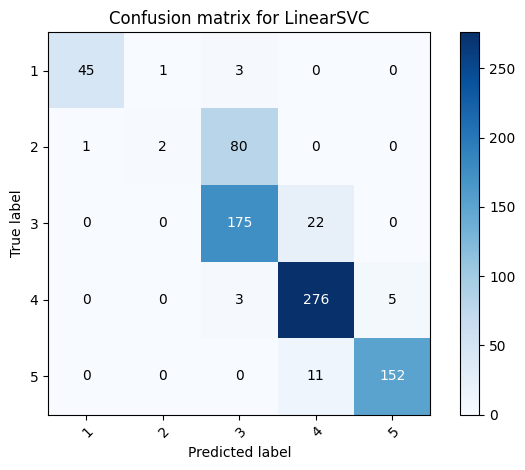

In [70]:
plot_confusion_matrix(cm_svc, labels, "Confusion matrix for LinearSVC")
plt.show()

#### Confusion Matrix Structure

There is some structure in this matrix. We can observe that:

- The model has a relatively high number of correct predictions (diagonal elements), especially for classes 3, 4, and 5.
- Class 2 seems to be commonly misclassified as Class 3, as indicated by the number 80 in the off-diagonal cell.
- Class 4 also has a high rate of correct classification, with some misclassifications primarily as Class 3.
- Class 5 has a fair number of correct classifications, but a considerable amount of misclassification as Class 4.

In [71]:
accuracy_svc = compute_accuracy(cm_svc)
print(f"SVM Classification Accuracy: {accuracy_svc:.2f}")

SVM Classification Accuracy: 0.84


### Multi-Layer Perceptron

I did the same thing as for the SVM. After using the best predictor, I used the output as the input of my custom functions.

In [72]:
mlp_best = clf_mlp.best_estimator_
predicted_labels_mlp = mlp_best.predict(X_test)
cm_mlp, labels = compute_confusion_matrix(y_test, predicted_labels_mlp)

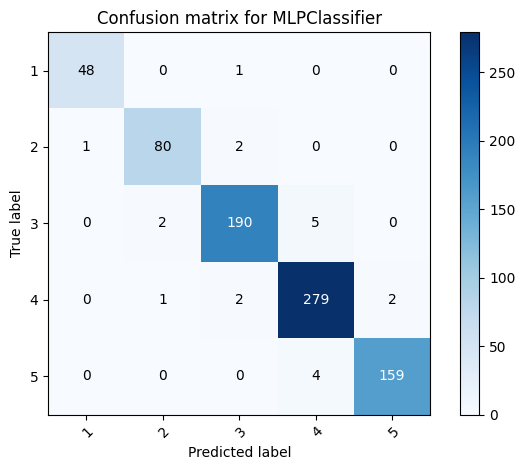

In [73]:
plot_confusion_matrix(cm_mlp, labels, "Confusion matrix for MLPClassifier")
plt.show()

#### Confusion Matrix Structure

Similarly to the SVM, there is structure in this matrix. We can observe that the classifier is precise and the diagonal elements are high. Misclassification occur rarely.

In [74]:
accuracy_mlp = compute_accuracy(cm_mlp)
print(f"MLP Classification Accuracy: {accuracy_mlp:.2f}")

MLP Classification Accuracy: 0.97


### Summary

It looks like the classification accuracy of the MLP is slightly better than that of the SVM. That being said, both models are fairly inaccurate. If I had more time and / or access to better computation resources, I would try the following to enhance the performance of the models:

- use the full dataset
- experiment with further interaction features
- experiment with the inclusion of the temporal information in the dataset to account for the change in movie taste over time and to get access to more complex analytical findings
- experiment with a larger set of hyperparmeter combinations for the models

# Task 2: MLP Classifier

In this task you will implement a multi-layer perceptron (MLP) for classification, the finite-differences approach for approximately computing the gradient of the loss with respect to the weights of the MLP, and train the MLP using the Adam optimizer (which is a variant of SGD that uses individual learning rates for each parameter). We consider the perceptron loss as our loss function.

*Hint: Read the whole description of this task before starting to code. Think about how you can implement a MLP in a modular fashion such that you can easily change the number of layers and activation functions.*

## Subtask 1: Classification Data

Download the "Classification" dataset. Once stored in a local folder, you can load the data as follows:

```python
import h5py
hf = h5py.File('classification.h5', 'r')
x_train = np.array(hf.get('x_train'))
y_train = np.array(hf.get('y_train'))
x_test = np.array(hf.get('x_test'))
y_test = np.array(hf.get('y_test'))
hf.close()
```

The matrices `x_train` and `x_test` have the following shapes: (number of samples) $\times$ (number of features). The matrices `y_train` and `y_test` have the following shapes: (number of samples) $\times$ (number of targets). Normalize the data using the `MinMaxScaler`.

□ Report the dataset statistics (number of features and training and test samples, number of targets).

In [75]:
import h5py

hf = h5py.File(assets_root / "classification.h5", "r")
x_train = np.array(hf.get("x_train"))
y_train = np.array(hf.get("y_train"))
x_test = np.array(hf.get("x_test"))
y_test = np.array(hf.get("y_test"))
hf.close()

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### Dataset Statistics

In [77]:
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Labels:\n{pd.Series(y_train.flatten()).value_counts()}")

Training data shape: (500, 2)
Test data shape: (10000, 2)
Labels:
0.0    256
1.0    244
Name: count, dtype: int64


## Subtask 2: Forward Propagation

Implement forward propagation for an MLP classifier with two hidden layers and ReLU activation function. Use small hidden layers, each containing 10 neurons. The MLP must have a single output. Initialize weights randomly as discussed in class. Initialize biases as all-zero vectors.

□ Briefly describe your implementation. How do you store the weights and biases?

*Hint: Maintain lists of weight matrices and biases vectors.*

*Hint: We will later (in the next assignment) replace the activation functions by other activation functions, so keep the activation function modular.*

I implemented forward propagation for an MLP classifier with the following approach:

**Weights and Biases Initialization**

I stored the weights in a list of `numpy` arrays, with each array representing the weights between two consecutive layers. These weights are initialized using the standard normal distribution to ensure that each neuron starts off learning a different function. This approach is particularly important for the ReLU activation function to avoid dead neurons. The biases are stored in a similar list format and initialized to zero vectors.

**Forward Propagation Function**

In the `forward_propagation` function, the input `x` is propagated through the network. For each layer, the linear combination of inputs and weights plus the bias is calculated, and the ReLU activation function is applied to this sum. The iteration over layers is performed using a `for` loop that zips together the weights and biases lists, ensuring that each step uses the corresponding parameters for that layer. I also made the function parametric in terms of `activation_fn` so that I can easily test different activation functions later on.

In [78]:
import numpy as np
from typing import Callable


def initialize_parameters(
    layer_sizes: list[int],
) -> tuple[list[np.ndarray], list[np.ndarray]]:
    """
    Initialize weights and biases for the MLP based on the provided layer sizes.
    """
    weights = [
        np.random.randn(layer_sizes[i], layer_sizes[i + 1])
        for i in range(len(layer_sizes) - 1)
    ]
    biases = [np.zeros((1, layer_sizes[i + 1])) for i in range(len(layer_sizes) - 1)]

    return weights, biases


def relu(z: np.ndarray) -> np.ndarray:
    """
    ReLU activation function.
    """
    return np.maximum(0, z)


def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Sigmoid activation function.
    """
    return 1 / (1 + np.exp(-z))


def softmax(x: np.ndarray) -> np.ndarray:
    """
    Softmax activation function.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def forward_propagation(
    x: np.ndarray,
    weights: list[np.ndarray],
    biases: list[np.ndarray],
    activation_fn: Callable[[np.ndarray], np.ndarray],
) -> np.ndarray:
    """
    Perform forward propagation through the MLP.
    """
    a = x
    for w, b in zip(weights, biases):
        z = np.dot(a, w) + b.squeeze()
        a = activation_fn(z)
    return a

## Subtask 3: Finite Difference Gradient & Optimization

In this task you will implement the finite difference approximation of the gradient. The forward function implemented in the previous task computes the loss function $l(x,y; W) = l(x,y; W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)}, ...)$, where $W^{(i)}$ and $b^{(i)}$ are the weight matrices and bias vectors of the $i^{th}$ hidden layer of the neural network—the number of hidden layers and the shapes of the corresponding weights and biases depend on the specific architecture. For $\epsilon > 0$, the partial derivative of the loss function with respect to weight $w_{jk}^{(i)}$ can be approximated by

$$
\frac{\partial l(x,y; W)}{\partial w_{jk}^{(i)}} = \frac{l(x,y; W') - l(x,y; W'')}{2\epsilon},
$$

where $W'$ equals $W$ except for $w_{jk}^{(i)}$ which is set to $w_{jk}^{(i)} + \epsilon$ and $W''$ equals $W$ except for $w_{jk}^{(i)}$ which is set to $w_{jk}^{(i)} - \epsilon$. The partial derivative with respect to bias terms can be approximated similarly.

Use the implemented approximated gradient to train the MLP. Implement training using the Adam optimizer [4]. You can import the optimizer using 

```python
from _stochastic_optimizers.py import AdamOptimizer
```

when you put stochastic `_stochastic_optimizers.py` in your local folder. 

The optimizer can be initialized using

```python
optimizer = AdamOptimizer(weights + biases, lr, 0.9, 0.999, 1e-08)
```

, where weights and biases are lists containing the weights
and biases of your MLP and `lr` is the learning rate, e.g., $10^{-3}$ (you might need to play with the learning rate to get good results). Once you have approximated the gradient using finite differences, you can update the parameters of the MLP using 

```python
optimizer.update_params(gradients + gradients biases)
```

, where gradients and gradients biases are lists of gradients for weights and biases respectively (using the same order as the lists you provided when initializing the optimizer). Make sure that your training converges. Test at least two different architectures and activation functions (e.g., sigmoid and ReLU).

□ Report plots showing the mean perceptron loss on the training and test data during training for all tested architectures. Also report the classification accuracy during training on training and test data.

□ Report the time for training for all tested architectures.

□ Do you observe any differences in performance for the different architectures and activation functions?


### Finite Difference Gradient

In [79]:
def compute_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the mean squared error loss.
    """
    return np.mean((y_true - y_pred) ** 2)


def compute_gradient(
    layer_idx: int,
    x: np.ndarray,
    y: np.ndarray,
    weights: list[np.ndarray],
    biases: list[np.ndarray],
    activation_fn: Callable[[np.ndarray], np.ndarray],
    epsilon: float = 1e-4,
    is_bias: bool = False,
) -> np.ndarray:
    """
    Compute the gradient using finite difference approximation for a single parameter (weight or bias).
    """
    param = biases[layer_idx] if is_bias else weights[layer_idx]
    gradient = np.zeros_like(param)

    for j in range(param.shape[0]):
        for k in range(param.shape[1] if len(param.shape) > 1 else 1):
            param_plus, param_minus = np.copy(param), np.copy(param)
            param_plus[j, k] += epsilon
            param_minus[j, k] -= epsilon

            if is_bias:
                biases_copy = biases.copy()
                biases_copy[layer_idx] = param_plus.reshape(-1, 1)
                loss_plus = compute_loss(
                    y, forward_propagation(x, weights, biases_copy, activation_fn)
                )
                biases_copy[layer_idx] = param_minus.reshape(-1, 1)
                loss_minus = compute_loss(
                    y, forward_propagation(x, weights, biases_copy, activation_fn)
                )
            else:
                weights_copy = weights.copy()
                weights_copy[layer_idx] = param_plus
                loss_plus = compute_loss(
                    y, forward_propagation(x, weights_copy, biases, activation_fn)
                )
                weights_copy[layer_idx] = param_minus
                loss_minus = compute_loss(
                    y, forward_propagation(x, weights_copy, biases, activation_fn)
                )

            gradient[j, k] = (loss_plus - loss_minus) / (2 * epsilon)

    return gradient


def finite_difference_gradient(
    x: np.ndarray,
    y: np.ndarray,
    weights: list[np.ndarray],
    biases: list[np.ndarray],
    activation_fn: Callable[[np.ndarray], np.ndarray],
    epsilon: float = 1e-4,
) -> tuple[list[np.ndarray], list[np.ndarray]]:
    """
    Compute the gradient using finite difference approximation.
    """
    gradients_weights = [
        compute_gradient(
            i, x, y, weights, biases, activation_fn, epsilon, is_bias=False
        )
        for i in range(len(weights))
    ]
    gradients_biases = [
        compute_gradient(i, x, y, weights, biases, activation_fn, epsilon, is_bias=True)
        for i in range(len(biases))
    ]

    return gradients_weights, gradients_biases

### Training

In [80]:
from _stochastic_optimizers import AdamOptimizer


def train_mlp(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_test: np.ndarray,
    y_test: np.ndarray,
    weights: list[np.ndarray],
    biases: list[np.ndarray],
    activation_fn: Callable[[np.ndarray], np.ndarray],
    epochs: int = 100,
    learning_rate: float = 1e-3,
):
    optimizer = AdamOptimizer(weights + biases, learning_rate, 0.9, 0.999, 1e-08)
    training_losses, testing_losses = [], []
    training_accuracies, testing_accuracies = [], []

    for epoch in tqdm(range(epochs), desc="Training MLP"):
        # Forward pass
        y_pred_train = forward_propagation(x_train, weights, biases, activation_fn)
        y_pred_test = forward_propagation(x_test, weights, biases, activation_fn)

        # Compute loss
        train_loss = compute_loss(y_train, y_pred_train)
        test_loss = compute_loss(y_test, y_pred_test)
        training_losses.append(train_loss)
        testing_losses.append(test_loss)

        # Compute accuracy
        train_accuracy = np.mean(np.round(y_pred_train) == y_train)
        test_accuracy = np.mean(np.round(y_pred_test) == y_test)
        training_accuracies.append(train_accuracy)
        testing_accuracies.append(test_accuracy)

        # Compute gradients and update parameters
        gradients_weights, gradients_biases = finite_difference_gradient(
            x_train, y_train, weights, biases, activation_fn
        )
        optimizer.update_params(gradients_weights, gradients_biases)

    return {
        "weights": weights,
        "biases": biases,
        "training_losses": training_losses,
        "testing_losses": testing_losses,
        "training_accuracies": training_accuracies,
        "testing_accuracies": testing_accuracies,
    }

#### Running the Training

The progress bars report not only the elapsed time but also the number of average iterations performed per second.
I parameterized the whole training process so that I just need to change the `architectures` and `activation_functions` lists to test different architectures and activation functions and a combination of them.

I am experimenting with the following architectures:

- Single hidden layer with 10 neurons
- Two hidden layers with 10 neurons each

I am using the following activation functions:

- ReLU
- Sigmoid
- Softmax

I report all the runtime and accuracy measurements via `print` statements in the codeblock below.

In [81]:
architectures = [
    [x_train.shape[1], 10, y_train.shape[1]],  # Single hidden layer, 10 neurons
    [x_train.shape[1], 10, 10, y_train.shape[1]],  # Two hidden layers, 10 neurons each
]
activation_functions = {"relu": relu, "sigmoid": sigmoid, "softmax": softmax}

results = {}
for architecture in architectures:
    for activation_name, activation_fn in activation_functions.items():
        key = f"Arch: {architecture}, Activation: {activation_name}"
        print(f"Testing {key}")

        # Initialize parameters
        weights, biases = initialize_parameters(architecture)

        # Train the MLP
        result = train_mlp(
            x_train, y_train, x_test, y_test, weights, biases, activation_fn
        )
        results[key] = result

        # Log the final loss and accuracy
        print(f"Final Training Loss: {result['training_losses'][-1]}")
        print(f"Final Testing Loss: {result['testing_losses'][-1]}")
        print(f"Final Training Accuracy: {result['training_accuracies'][-1]}")
        print(f"Final Testing Accuracy: {result['testing_accuracies'][-1]}")
        print()

Testing Arch: [2, 10, 1], Activation: relu


Training MLP: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.02it/s]


Final Training Loss: 0.41730886815533047
Final Testing Loss: 0.40009122243014006
Final Training Accuracy: 0.512
Final Testing Accuracy: 0.5158

Testing Arch: [2, 10, 1], Activation: sigmoid


Training MLP: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.78it/s]


Final Training Loss: 0.2886466247558139
Final Testing Loss: 0.2864918522367812
Final Training Accuracy: 0.512
Final Testing Accuracy: 0.5158

Testing Arch: [2, 10, 1], Activation: softmax


Training MLP: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.87it/s]


Final Training Loss: 0.48604972572290783
Final Testing Loss: 0.48410316606543785
Final Training Accuracy: 0.512
Final Testing Accuracy: 0.5158

Testing Arch: [2, 10, 10, 1], Activation: relu


Training MLP: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.15it/s]


Final Training Loss: 4.239063102325914
Final Testing Loss: 3.988938611559238
Final Training Accuracy: 0.154
Final Testing Accuracy: 0.1216

Testing Arch: [2, 10, 10, 1], Activation: sigmoid


Training MLP: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.22it/s]


Final Training Loss: 0.3373459700063662
Final Testing Loss: 0.3405047541545418
Final Training Accuracy: 0.488
Final Testing Accuracy: 0.4842

Testing Arch: [2, 10, 10, 1], Activation: softmax


Training MLP: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.83it/s]

Final Training Loss: 0.4860520058067892
Final Testing Loss: 0.4841031700004734
Final Training Accuracy: 0.512
Final Testing Accuracy: 0.5158



### Mean Perceptron Loss

In [82]:
import matplotlib.pyplot as plt
import numpy as np


def create_report_plot():
    # Prepare data for bar chart
    architectures = []
    train_losses = []
    test_losses = []

    for key, value in results.items():
        architectures.append(key)
        train_losses.append(np.mean(value["training_losses"]))
        test_losses.append(np.mean(value["testing_losses"]))

    # Number of bars
    n_bars = len(architectures)

    # Positions of bars on x-axis
    barWidth = 0.3
    r1 = np.arange(n_bars)
    r2 = [x + barWidth for x in r1]

    # Create bar chart
    plt.figure(figsize=(12, 6))

    plt.bar(
        r1,
        train_losses,
        color="blue",
        width=barWidth,
        edgecolor="grey",
        label="Training Loss",
    )
    plt.bar(
        r2,
        test_losses,
        color="red",
        width=barWidth,
        edgecolor="grey",
        label="Testing Loss",
    )

    # Add labels
    plt.xlabel("Architecture and Activation Function", fontweight="bold")
    plt.xticks([r + barWidth for r in range(n_bars)], architectures, rotation=45)
    plt.ylabel("Mean Perceptron Loss")
    plt.title("Comparison of Mean Perceptron Loss Across Different Architectures")

    plt.legend()
    plt.show()

As the plot below displays, we can observe a performance difference between the different architectures and activation functions. The number of hidden layers also influence the results.

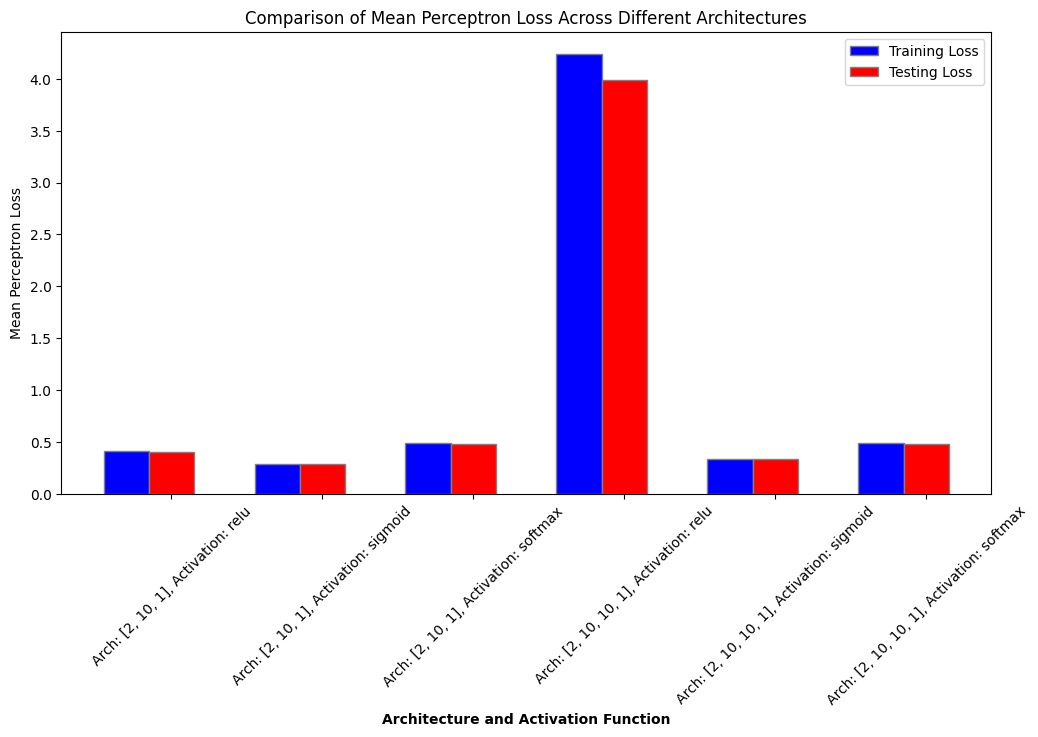

In [83]:
create_report_plot()